**ADVERSARIAL ATTACKS AND DEFENCES IN CONVOLUTIONAL NEURAL NETWORK   **  
Created by,
*  Name: **Sutharshan Shanmugarajah**
*  ID: **23092351**
*  Git Repository:








In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data and reshape
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - accuracy: 0.9160 - loss: 0.2761 - val_accuracy: 0.9824 - val_loss: 0.0517
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.9858 - loss: 0.0455 - val_accuracy: 0.9884 - val_loss: 0.0336
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.9912 - loss: 0.0267 - val_accuracy: 0.9909 - val_loss: 0.0292
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.9932 - loss: 0.0206 - val_accuracy: 0.9892 - val_loss: 0.0304
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - accuracy: 0.9957 - loss: 0.0137 - val_accuracy: 0.9926 - val_loss: 0.0264


In [10]:
def fgsm_attack(image, epsilon, gradient):
    perturbation = epsilon * np.sign(gradient)
    return image + perturbation

# Select an image from test set
image = x_test[0:1]
label = y_test[0:1]

# Convert image to a TensorFlow tensor
image = tf.convert_to_tensor(image) # Convert image to TensorFlow tensor

# Prediction Before Attack
original_prediction = model.predict(image)
original_label = np.argmax(original_prediction)

with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.categorical_crossentropy(label, prediction)

# Compute gradient
gradient = tape.gradient(loss, image)
adversarial_image = fgsm_attack(image, epsilon=0.1, gradient=gradient)

# Prediction After Attack
adv_prediction = model.predict(adversarial_image)
adv_label = np.argmax(adv_prediction)

# Apply Defense - Adversarial Training
x_train_adv = np.array([fgsm_attack(x, 0.1, gradient) for x in x_train])
x_train_adv = x_train_adv.reshape(x_train.shape)
x_train_combined = np.concatenate([x_train, x_train_adv])
y_train_combined = np.concatenate([y_train, y_train])

model.fit(x_train_combined, y_train_combined, epochs=5, validation_data=(x_test, y_test))

defended_prediction = model.predict(adversarial_image)
defended_label = np.argmax(defended_prediction)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 122s 32ms/step - accuracy: 0.9984 - loss: 0.0048 - val_accuracy: 0.9908 - val_loss: 0.0596
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 139s 32ms/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9915 - val_loss: 0.0420
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 143s 32ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9916 - val_loss: 0.0493
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 136s 30ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9917 - val_loss: 0.0512
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 113s 30ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9917 - val_loss: 0.0609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


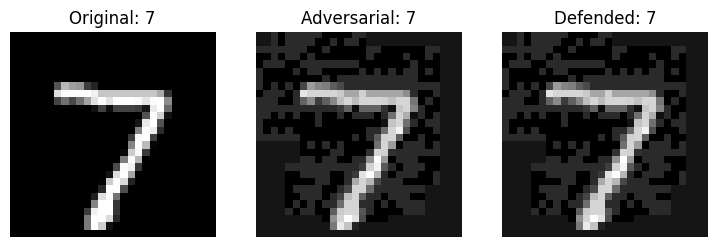

In [9]:
# Plot results
plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.title(f"Original: {original_label}")
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Adversarial: {adv_label}")
plt.imshow(adversarial_image.numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Defended: {defended_label}")
plt.imshow(adversarial_image.numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.savefig('results1.png')
plt.show()

In [4]:
def evaluate_model(model, x_test, y_test, epsilon):
    correct = 0
    for i in range(len(x_test)):
        # Convert image to a TensorFlow tensor before watching it
        image = tf.convert_to_tensor(x_test[i:i+1])
        label = y_test[i:i+1]

        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.categorical_crossentropy(label, prediction)

        gradient = tape.gradient(loss, image)
        adversarial_image = fgsm_attack(image, epsilon, gradient)
        adversarial_prediction = model(adversarial_image)

        if np.argmax(adversarial_prediction) == np.argmax(label):
            correct += 1

    accuracy = correct / len(x_test)
    print(f"Accuracy after attack with epsilon {epsilon}: {accuracy * 100:.2f}%")

In [5]:
evaluate_model(model, x_test, y_test, epsilon=0.1)

Accuracy after attack with epsilon 0.1: 80.94%


In [16]:
def evaluate_multiple_numbers(model, x_test, y_test, epsilon):
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    indices = np.random.choice(len(x_test), 10, replace=False)

    correct_count = 0

    for i, idx in enumerate(indices):
        # Convert image to TensorFlow tensor here
        image = tf.convert_to_tensor(x_test[idx:idx+1])
        label = y_test[idx:idx+1]

        # Original Prediction
        orig_pred = np.argmax(model(image))

        # Compute Adversarial Example
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.categorical_crossentropy(label, prediction)

        gradient = tape.gradient(loss, image)
        adversarial_image = fgsm_attack(image, epsilon, gradient)

        # Adversarial Prediction
        adv_pred = np.argmax(model(adversarial_image))

        # Defense
        defended_image = tf.clip_by_value(adversarial_image, 0, 1)
        defended_pred = np.argmax(model(defended_image))

        # Display Images and Predictions
        axes[0, i].imshow(image.numpy().squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original: {orig_pred}")
        axes[0, i].axis('off')

        axes[1, i].imshow(adversarial_image.numpy().squeeze(), cmap='gray')
        axes[1, i].set_title(f"Post Attack: {adv_pred}")
        axes[1, i].axis('off')

        axes[2, i].imshow(defended_image.numpy().squeeze(), cmap='gray')
        axes[2, i].set_title(f"Post Defence: {defended_pred}")
        axes[2, i].axis('off')

        if defended_pred == np.argmax(label):
            correct_count += 1

    plt.tight_layout()
    plt.savefig('results2.png')
    plt.show()

    print(f"Model Accuracy After Defense: {correct_count / len(indices) * 100:.2f}%")

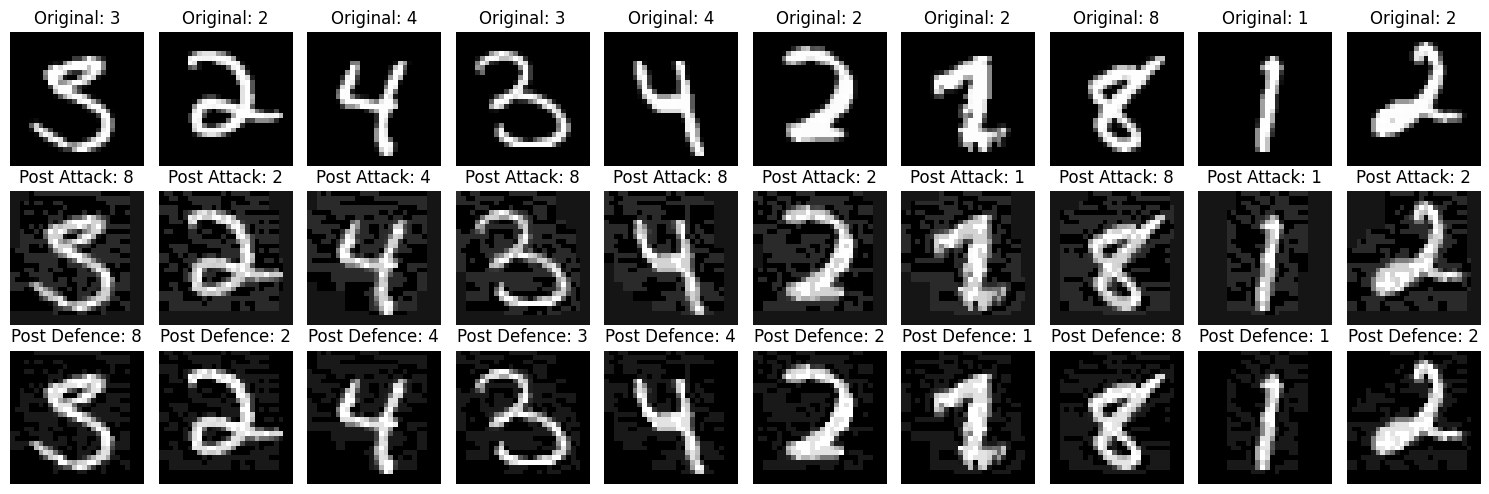

Model Accuracy After Defense: 80.00%


In [22]:
evaluate_multiple_numbers(model, x_test, y_test, epsilon=0.1)


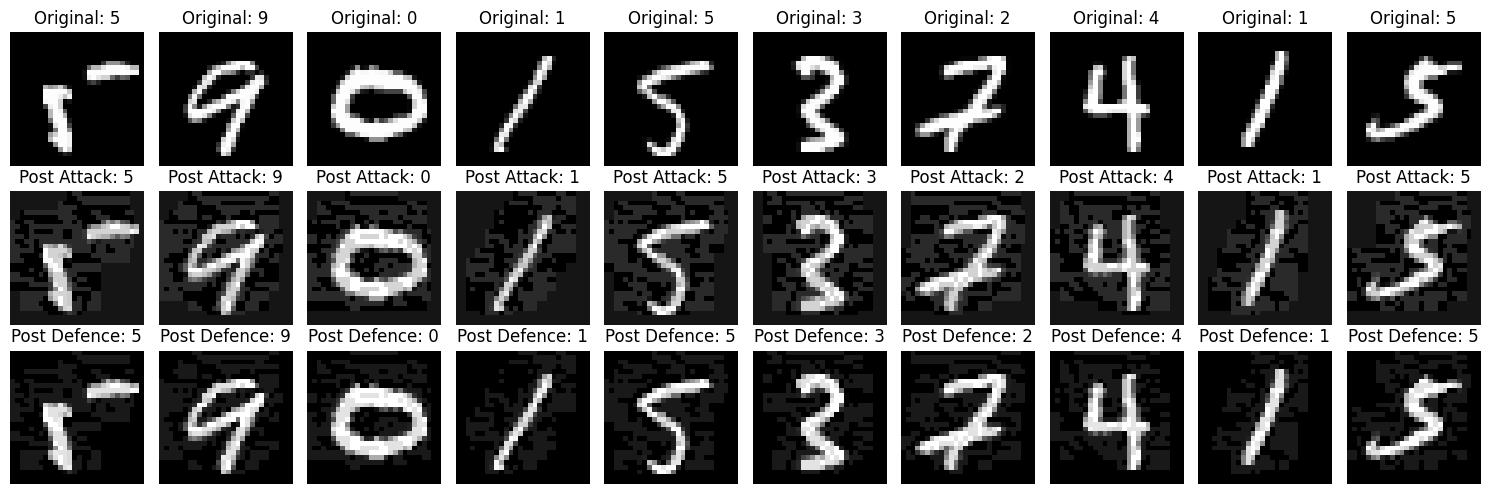

Model Accuracy After Defense: 90.00%


In [21]:
evaluate_multiple_numbers(model, x_test, y_test, epsilon=0.1)
